In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


df = pd.read_csv('../data/processed/olist_transactional_master.csv')

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df_rfm_source = df[df['order_status'] == 'delivered'].copy()

present_date = df_rfm_source['order_purchase_timestamp'].max() + dt.timedelta(days=1)

print(f"📅 Fecha de corte para el análisis: {present_date}")

rfm = df_rfm_source.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (present_date - x.max()).days, # Recencia: Días desde última compra
    'order_id': 'nunique',                                               # Frecuencia: Conteo de órdenes ÚNICAS
    'price': 'sum'                                                       # Monetización: Suma del valor de items
}).reset_index()

rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

labels_asc = [1, 2, 3, 4, 5]
labels_desc = [5, 4, 3, 2, 1]

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=labels_desc)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=labels_asc)

rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=labels_asc)

rfm['RFM_Score_String'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


rfm['RFM_Score_Sum'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

def segment_customer(score_sum):

    if score_sum >= 12:
        return 'Gold'
    elif score_sum >= 8:
        return 'Silver'
    else:
        return 'Bronze'

rfm['Segment'] = rfm['RFM_Score_Sum'].apply(segment_customer)

print("\n--- MUESTRA DE CLIENTES SEGMENTADOS ---")
print(rfm[['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'RFM_Score_Sum', 'Segment']].head())

📅 Fecha de corte para el análisis: 2018-08-30 15:00:37

--- MUESTRA DE CLIENTES SEGMENTADOS ---
                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    129.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     18.90   
2  0000f46a3911fa3c0805444483337064      537          1     69.00   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99   
4  0004aac84e0df4da2b147fca70cf8255      288          1    180.00   

   RFM_Score_Sum Segment  
0              9  Silver  
1              6  Bronze  
2              4  Bronze  
3              4  Bronze  
4              8  Silver  


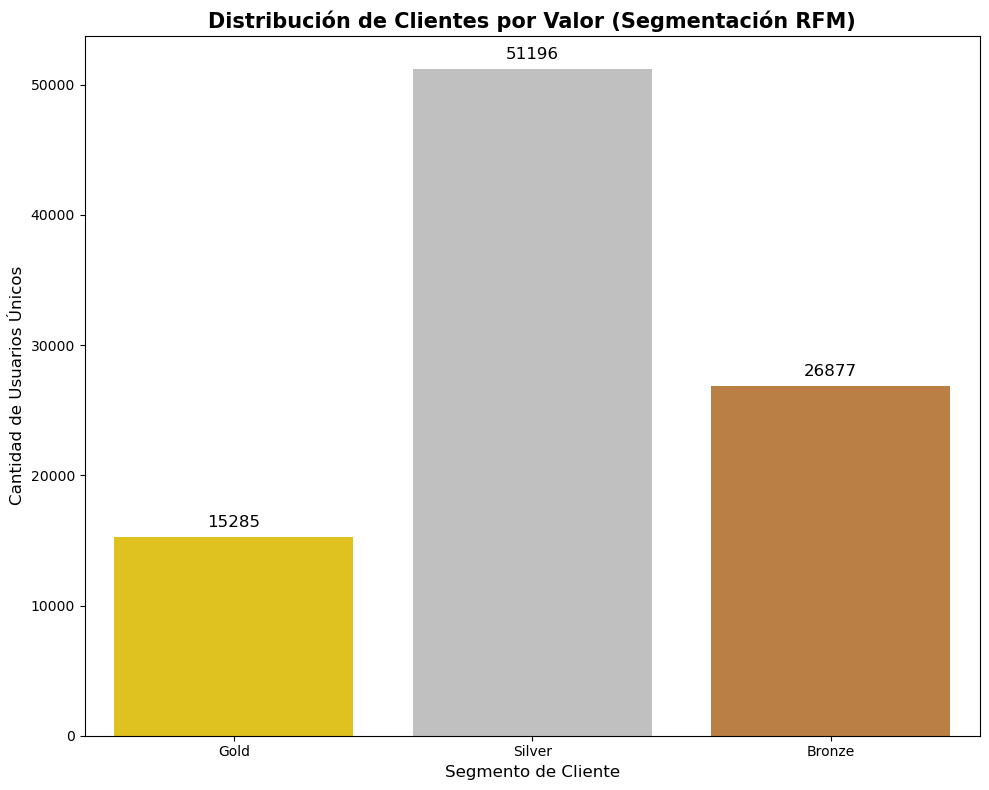

💾 Análisis RFM guardado exitosamente.


In [4]:
plt.figure(figsize=(10, 8))
colors = {'Gold': '#FFD700', 'Silver': '#C0C0C0', 'Bronze': '#CD7F32'}

ax = sns.countplot(
    x='Segment', 
    data=rfm, 
    hue='Segment',
    palette=colors, 
    order=['Gold', 'Silver', 'Bronze'],
    legend=False 
)

plt.title('Distribución de Clientes por Valor (Segmentación RFM)', fontsize=15, fontweight='bold')
plt.xlabel('Segmento de Cliente', fontsize=12)
plt.ylabel('Cantidad de Usuarios Únicos', fontsize=12)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='bottom',
        fontsize=12, 
        color='black', 
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout() 
plt.show()

rfm.to_csv('../data/processed/rfm_final_results.csv', index=False)
print("💾 Análisis RFM guardado exitosamente.")